In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from multibind.multibind import MultibindScanner
from pathlib import Path

from matplotlib.ticker import MultipleLocator

Matplotlib is building the font cache; this may take a moment.


In [2]:
def proton_uptake(scanner, site=None):

        msp = scanner.results.microstate_probs
        nprot = []

        index_map = {'left': 1,
                     'center': 2,
                     'right': 3,
                     'side': 1}

        for s in scanner.c.states.name.values:
            nprot.append(int(s[index_map[site]]))

        nprot = np.array(nprot)

        pH = scanner.results.pH.values

        expected = []

        for p in pH:
            prob = (nprot * msp.sel({"pH": p}).values).sum()
            expected.append(prob)

        return np.array(pH), np.array(expected)

In [3]:
def load_nmr_data(normalize=True):
    nmr_data_dir = Path("data")
    center = np.genfromtxt(nmr_data_dir / "nmr_center.csv", delimiter=",", dtype=np.float64)
    side = np.genfromtxt(nmr_data_dir / "nmr_side.csv", delimiter=",", dtype=np.float64)

    if normalize:
        center[:, 0] = center[:, 0] - center[:, 0].min()
        center[:, 0] = center[:, 0] / center[:, 0].max()
        side[:, 0] = side[:, 0] - side[:, 0].min()
        side[:, 0] = side[:, 0] / side[:, 0].max()

    return center[:, [1, 0]], side[:, [1, 0]]

In [4]:
center_rundir = Path() / 'runs/9dfbfebf-46c2-4b0f-9f61-88a9d3005b9a-center/'
side_rundir = Path() / 'runs/0f70019b-8a3d-4ada-a6be-81f80564af7f-side/'
simult_rundir = Path() / 'runs/c13e70b4-ee59-45f8-b113-ab0ed37bbeb3-None/'

In [14]:
def make_plot(rundir):
    fig, ax = plt.subplots(figsize=(4,2.5))
    
    fitsite = str(rundir).split('-')[-1]
    print(fitsite)
    
    if fitsite == "None":
        dt_center = '-'
        dt_side = '-'
    else:
        dt_center = '-' if fitsite == "center" else '--'
        dt_side = '-' if fitsite == "side" else '--'
    
    center, side = load_nmr_data()
    
    scanner = MultibindScanner(rundir / 'inputs' / 'states.csv',
                               rundir / 'inputs' / 'best_graph.csv')
    
    scanner.run(concentrations={'pH': np.linspace(0, 14, 50)})
    
    ax.set_xlabel("pH")
    ax.set_ylabel(r"$\langle x \rangle$")
    
    ax.plot(center[:,0], center[:, 1], 's', color='black', label="Central")
    ax.plot(side[:,0], side[:, 1], '^', color='black', label="Terminal")
    
    center_label = "Predicted" if dt_center == "--" else "Fit"
    side_label = "Predicted" if center_label == "Fit" else "Fit"
    
    ax.plot(*proton_uptake(scanner, site='center'), dt_center, color='black', label=center_label)
    ax.plot(*proton_uptake(scanner, site='side'), dt_side, color='black', label=side_label)
    
    ax.set_xlim([3, 13])
    ax.set_ylim([0, 1])
    
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    sns.despine(offset=5, ax=ax)
    
    plt.tight_layout()
    
    plt.legend(loc='best')
    
    plt.savefig(f"pubimg/{fitsite}.pdf")

center


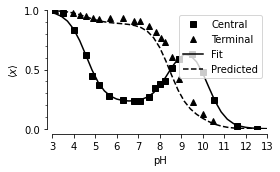

None


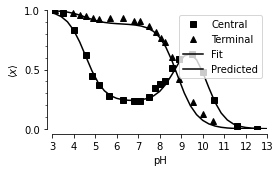

side


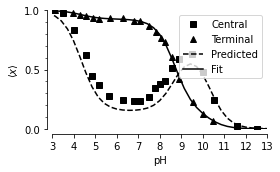

In [15]:
make_plot(center_rundir); plt.show()
make_plot(simult_rundir); plt.show()
make_plot(side_rundir); plt.show()